In [1]:
t = pd.read_csv("data/cate_5_list.csv", encoding='utf-8-sig')

In [2]:
t

,index,keys,values
0,0,프로바이오틱스,"유산균, 프로바이오틱스, 생유산균"
1,1,기타다이어트식품,다이어트쉐이크
2,2,뷰티푸드,버닝티
3,3,헬스보충제,"단백질보충제, 헬스보충제, 게이너, 프로틴"
4,4,곤약쌀,"곤약쌀, 곤약미"
...,...,...,...
93,93,석류즙,석류즙
94,94,기타건강즙,"굼벵이즙, 흑염소진액, 건강즙"
95,95,꿀,벌화분
96,96,비타민E,비타민E


## 설정 
#### 
- 폰트는 개인 설정에 맞게 바꿀 것                           
- 마지막 옵션은 최대 표시량을 바꿔주는 옵션이므로 필요에 따라 사용할 것

In [3]:
import os
import sys
import urllib.request
import json

In [4]:
import numpy as np
import pandas as pd
import copy

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="/System/Library/Fonts/Supplemental/AppleMyungjo.ttf").get_name()
rc('font', family=font_name)

In [ ]:
 # pd.set_option('display.max_columns', 100)

## 준비작업
#### 
- cate_5_list.csv 파일은 카테고리별 검색 키워드를 작성해둔 파일
- 키워드는 최대한 다른 키워드와 겹치지 않는 선에서 선정하였으며
    - ex. "노니"의 경우 "노니비누"와 겹치지 않게 노니원액, 노니분말 등으로 선정
- 기본적으로는 카테고리 이름에서 벗어나지 않도록 함
- 부르는 방법이 다양한 경우 모두 포함함 
    - ex. "Qoq10"의 경우 코큐텐, 코엔자임큐텐, 코엔자임Q10 등을 모두 선정함
- 기타영양제 처럼 키워드가 모호한 경우 제외함 (3개가 빠짐)

In [7]:
search_word = pd.read_csv("data/cate_5_list.csv", encoding = "utf-8-sig", index_col = "index")

In [8]:
search_word = search_word[search_word["values"].isna() == False]

In [9]:
search_word

,keys,values
index,,
0,프로바이오틱스,"유산균, 프로바이오틱스, 생유산균"
1,기타다이어트식품,다이어트쉐이크
2,뷰티푸드,버닝티
3,헬스보충제,"단백질보충제, 헬스보충제, 게이너, 프로틴"
4,곤약쌀,"곤약쌀, 곤약미"
...,...,...
92,건강환/정,"양배추환, 블루베리환, 여주환, 굼벵이환"
93,석류즙,석류즙
94,기타건강즙,"굼벵이즙, 흑염소진액, 건강즙"


#### 네이버 API 사용을 위한 데이터 처리 
#### 
- 불러온 cate_5_list를 body에 필요한 딕셔너리 타입으로 정리
- API사용을 위한 검색어 딕셔너리 구조는 {"groupName":[키워드 그룹의 이름], "keywords" : [실제 검색할 키워드]}형태여야 하며, 
- 딕셔너리의 keywords에 해당하는 부분이 검색 대상 키워드가 됨 
- 다르게말하자면, groupName은 검색하지 않음 

In [10]:
search_dict = []
list_key = []
list_value = []

for index in range(len(search_word)) : 
    value_name = list(search_word["keys"])[index] #search_word의 Keys 칼럼을 리스트화 한 후, 순서대로 가져옴
    value_words = (list(search_word["values"])[index]).split(",") #search_word의 values 칼럼을 리스트화 한 후, 순서대로 가져옴
    #dict_value를 split(",")하는 이유는, 개별 키워드가 띄어쓰기로 구분된 리스트 형태여야 하기 때문 
    #ex. "유산균, 프로바이오틱스"(X), "유산균", "프로바이오틱스" (O)
    search_dict.append({"groupName" : value_name, "keywords" : value_words}) 
    #search_dict 리스트에 딕셔너리 타입으로 추가시킴 
    list_key.append(value_name)
    list_value.append(value_words)

In [11]:
search_dict

[{'groupName': '프로바이오틱스', 'keywords': ['유산균', ' 프로바이오틱스', ' 생유산균']},
 {'groupName': '기타다이어트식품', 'keywords': ['다이어트쉐이크']},
 {'groupName': '뷰티푸드', 'keywords': ['버닝티']},
 {'groupName': '헬스보충제', 'keywords': ['단백질보충제', ' 헬스보충제', ' 게이너', ' 프로틴']},
 {'groupName': '곤약쌀', 'keywords': ['곤약쌀', ' 곤약미']},
 {'groupName': '다이어트차', 'keywords': ['허벌티', ' 클렌즈티 ', ' 다이어트차']},
 {'groupName': '곤약젤리', 'keywords': ['곤약젤리']},
 {'groupName': '식이섬유', 'keywords': ['식이섬유', ' 차전자피식이섬유 ']},
 {'groupName': '가르시니아', 'keywords': ['가르시니아', '가르시니아HCA']},
 {'groupName': '기타곤약가공품', 'keywords': ['곤약쫀드기', ' 곤약볶음밥', ' 곤약면', ' 곤약떡볶이 ']},
 {'groupName': '다이어트바', 'keywords': ['단백질바', ' 시리얼바', ' 다이어트바']},
 {'groupName': '잔티젠', 'keywords': ['잔티젠']},
 {'groupName': '레몬밤', 'keywords': ['레몬밤분말', ' 레몬밤 ']},
 {'groupName': 'CLA', 'keywords': ['공액리놀레산', ' CLA']},
 {'groupName': '히알루론산', 'keywords': ['히알루론산']},
 {'groupName': '카테킨', 'keywords': ['카테킨']},
 {'groupName': '와일드망고', 'keywords': ['와일드망고', ' 와일드망고분말']},
 {'groupName': '곤약', 'k

#### 네이버 API 사용시 주의사항
#### 
- 검색 트렌드랩은 총 5개 그룹까지 검색이 가능하기 때문에, 그 이상으로 검색하고 싶다면 나눠서 검색해야 함
- 또한 정확한 키워드의 검색 양이 아닌 상대적인 값만 제시함(최대 검색 수를 100으로 설정)
- 따라서 정확한 비교를 위해서는 기준이 될 값을 선택하여
- 5개 그룹 중 한 그룹에 항상 할당해줘야 함 
        - ex. 1회차 검색 : a, b, c, d, e / 2회차 검색 : a, f, g, h, i ...
- 아래 standard 변수는 기준이 될 값을 할당한 것(프로바이오틱스)

In [12]:
standard = copy.deepcopy(search_dict[0])
standard

{'groupName': '프로바이오틱스', 'keywords': ['유산균', ' 프로바이오틱스', ' 생유산균']}

#### 여기서부터 네이버 API
#### 
- client id, secret은 수정 필요 
- 데이터를 가져올 함수 (get_trend)를 만들고, body는 네이버 API 양식에 맞춰 구성되어야 함 

In [13]:
import urllib.request

def get_trend(body):
    url = "https://openapi.naver.com/v1/datalab/search"
    client_id = "9cwQ_sTbcTi7XoLKdYHy"
    client_secret = "0nfPtUxCOU"
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    request.add_header("Content-Type","application/json")
    response = urllib.request.urlopen(request, data=body.encode("utf-8"))

    return json.loads(response.read().decode('utf-8'))


#### 검색 리스트 생성 
#### 
- 우선 기준값인 프로바이오틱스를 제외한 새 리스트(crop_dict)를 만든 다음
- 검색어 그룹 4개를 한 개의 원소로 묶어서 넣은 리스트(split_list)를 만든다 
- 여기서 4개를 묶는 이유는, 4개 + 기준값 1개를 검색할 것이기 때문

In [14]:
crop_dict = search_dict[1:]
split_list = [crop_dict[i:i+4] for i in range(0, len(crop_dict), 4)]

In [15]:
split_list

[[{'groupName': '기타다이어트식품', 'keywords': ['다이어트쉐이크']},
  {'groupName': '뷰티푸드', 'keywords': ['버닝티']},
  {'groupName': '헬스보충제', 'keywords': ['단백질보충제', ' 헬스보충제', ' 게이너', ' 프로틴']},
  {'groupName': '곤약쌀', 'keywords': ['곤약쌀', ' 곤약미']}],
 [{'groupName': '다이어트차', 'keywords': ['허벌티', ' 클렌즈티 ', ' 다이어트차']},
  {'groupName': '곤약젤리', 'keywords': ['곤약젤리']},
  {'groupName': '식이섬유', 'keywords': ['식이섬유', ' 차전자피식이섬유 ']},
  {'groupName': '가르시니아', 'keywords': ['가르시니아', '가르시니아HCA']}],
 [{'groupName': '기타곤약가공품', 'keywords': ['곤약쫀드기', ' 곤약볶음밥', ' 곤약면', ' 곤약떡볶이 ']},
  {'groupName': '다이어트바', 'keywords': ['단백질바', ' 시리얼바', ' 다이어트바']},
  {'groupName': '잔티젠', 'keywords': ['잔티젠']},
  {'groupName': '레몬밤', 'keywords': ['레몬밤분말', ' 레몬밤 ']}],
 [{'groupName': 'CLA', 'keywords': ['공액리놀레산', ' CLA']},
  {'groupName': '히알루론산', 'keywords': ['히알루론산']},
  {'groupName': '카테킨', 'keywords': ['카테킨']},
  {'groupName': '와일드망고', 'keywords': ['와일드망고', ' 와일드망고분말']}],
 [{'groupName': '곤약', 'keywords': ['곤약세라마이드', ' 곤약세라미드']},
  {'groupName

#### 반복문 
#### 
- body 값을 바꿔가며 get_trend 함수를 실행하는 반복문을 작성 
- insert_word가 검색할 값에 해당하며 이 단계에서 split_list의 원소를 가져오고 standard 변수를 결합한다 
- 여기서 split_list를 먼저 가져온 다음 standard 변수를 더했기 때문에, 
- 매번 검색마다 5번째 자리가 기준값인 프로바이오틱스가 된다 

In [16]:
search_result = []

for i in range(len(split_list)) : 
    insert_words = []
    insert_words = copy.deepcopy(split_list[i])
    insert_words.append(standard)
    
    body = {
        "startDate":"2021-04-09",
        "endDate":"2021-04-10",
        "timeUnit":"date",
        "keywordGroups": insert_words
    
        }
        
    body = json.dumps(body, indent=4, ensure_ascii=False)
    
    search_result.append(get_trend(body))

In [17]:
#잘 가져왔는지 확인(split_list와 length가 맞으면 문제없음)
len(search_result)

24

#### 참고사항 
#### 
- 네이버 API에서 반환되는 결과값의 구조가 약간? 복잡하기 때문에 아래와 같이 긴 코드가 작성되었다 
- 일단 한번의 실행값은 다음과 같은 딕셔너리 구조를 갖고 있음
- result 안에 5개 키워드 그룹에 대한 검색결과가 다 들어가 있어서 저걸 잘 빼내는 것이 관건 
- 그리고 아래와 같은 딕셔너리가 검색 횟수 만큼 생성되어 리스트에 들어가있다
- 키워드가 25개라서 5개씩 5번 검색했다면 결과 리스트에는 딕셔너리가 5개라는 의미  

```
{'startDate': '2018-01-01',
  'endDate': '2021-04-10',
  'timeUnit': 'date',
  'results': [{'title': '기타다이어트식품',
    'keywords': ['다이어트쉐이크'],
    'data': [{'period': '2018-01-01', 'ratio': 0.42939},
     {'period': '2018-01-02', 'ratio': 0.58726},
     ...]}
```     
##### 키가 result일때 value값의 구조
```
'results': [{'title': '기타다이어트식품',
    'keywords': ['다이어트쉐이크'],
    'data': [{'period': '2018-01-01', 'ratio': 0.42939},
     {'period': '2018-01-02', 'ratio': 0.58726},
     {'period': '2018-01-03', 'ratio': 0.54095},
     {'period': '2018-01-04', 'ratio': 0.50685},
     {'period': '2018-01-05', 'ratio': 0.44286},
     {'period': '2018-01-06', 'ratio': 0.38898},
```

- result의 value는 위와 같은 구조로
- 5개 키워드 그룹에 대한 검색 결과(개별 검색 결과는 딕셔너리) 리스트가 value에 들어가있다 
- 기준값이 되는 프로바이오틱스를 포함하여 검색 한번에 5개 키워드 그룹을 검색하였으므로, 
- 5개 결과값에 대한 5개의 딕셔너리가 만들어졌다 
- 각각의 딕셔너리는 title(키워드 그룹명), keyword(검색 키워드), data(결과값)로 구성된다



In [ ]:
search_result

In [ ]:
#검색한 날짜 리스트 보기
period_list = [each["period"] for each in search_result[0]["results"][0]["data"]]

In [ ]:
#결과값 리스트 보기 
ratio_list = [each["ratio"] for each in search_result[0]["results"][0]["data"]]

In [ ]:
#2018-1-1~2021-04-10 은 1196일
len(period_list), len(ratio_list)

#### result를 데이터 프레임으로 만들기 
- 우선 빈 데이터 프레임을 하나 만들어서, 계속 가져올 필요가 없는 date값을 column으로 넣어준다
- 그 다음, 기준값인 프로바이오틱스도 미리 데이터 프레임에 넣어주었다 

In [ ]:
df_result = pd.DataFrame()
df_result["date"] = period_list
df_result.head()

In [ ]:
probio = search_result[23]["results"][2]["title"]
probio_ratio = [each["ratio"] for each in search_result[23]["results"][2]["data"]]
df_result[probio] = probio_ratio

In [ ]:
df_result.head()

#### 데이터프레임을 구성하는 반복문 
#### 
- merge를 사용해 위에서 생성해둔 df_result에 결과를 결합하는 반복문을 만들었다
- merge를 사용한 이유는, result가 키워드 마다 길이가 다르기 때문에 그냥 합치면 인덱스 길이가 안맞아서 에러가 나기 때문이다
- 키워드 마다 길이가 다른 이유는, 네이버 API에서 특정 일의 검색량이 0인 경우
- 값이 0으로 저장되는 게 아니라 아예 그 값을 결과에 포함시키지 않기 때문
    - ex. 예를 들어 어떤 성분이 2019년 1월 1일에 처음으로 등장했다면, 2018년 1월 부터의 기록은 아예 없어서 (1196-365)개의 값만을 갖게 됨
- 이에 df_dummy 라는 데이터프레임을 만들어, date 컬럼에 날짜를, 카테고리 명을 이름으로 한 컬럼에 결과값을 넣고
- date를 기준(left_on, right_on)으로 기존 데이터 프레임(df_result)에 merge하였다 
#### 
- 안쪽 for문은 한번 검색에 해당하는 5개 그룹의 결과값 중 기준값을 제외한 나머지 결과값을 가져오고
- 바깥쪽 for문은 안쪽 for문을 전체 검색 수 만큼 반복하기 위한 구조
    - ex. 매번 기준값을 포함해 5 그룹씩 7번 검색했다면 안쪽 for문은 4번, 바깥쪽 for문은 7번 실행되어야 한다  

In [ ]:
for i in range(len(search_result)) :
    for order in range((len(search_result[i]["results"]))-1)  :
       
        df_dummy = pd.DataFrame()
        
        date_list = [each["period"] for each in search_result[i]["results"][order]["data"]]
        ratio_list = [each["ratio"] for each in search_result[i]["results"][order]["data"]]
        column_name = search_result[i]["results"][order]["title"]
        
        df_dummy["date"] = date_list 
        df_dummy[column_name] = ratio_list
        
        df_result = pd.merge(left = df_result, right = df_dummy, how = "outer" , left_on = "date", right_on = "date" )
       
        print(column_name)
        

In [ ]:
# 빈값은 0으로 채워준다
df_result = df_result.fillna(0)

In [ ]:
#여기서 파일 저장 한번 
# df_result.to_csv("data/search_result.csv", encoding = "utf-8-sig")

In [ ]:
#이제야 분석을 위한 데이터프레임이 완성되었다 
df_result.head()

#### 실제값을 반영한 데이터프레임
#### 
- 네이버 트렌드랩은 상대값만을 보여주기 때문에
- 절대값 계산을 위해선 별도의 데이터가 필요하다 
- 여기에서는 네이버 광고주 센터에서 확인할 수 있는 월간 검색 수를 사용

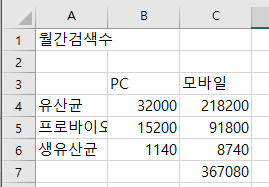

- 프로바이오틱스의 2021-03-10 ~ 2021-04-10 (1개월)의 상댓값의 총합은 162.5559 이며, 
- 검색량의 실제 총합은 367080이므로 
- 367080/162.5559를 한 값이 상댓값 1에 해당하는 검색의 절대량
(스케일링을 위한 값 하나만 있으면 되기 때문에 그냥 엑셀에서 따로 계산...ㅎㅎ)
- scaler = 2258.17661650362

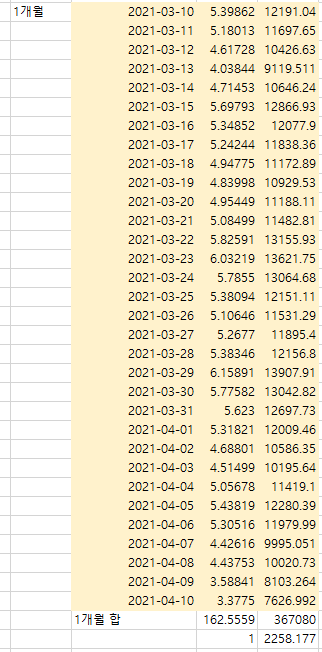

#### 새로운 데이터프레임 만들기
#### 
- df_result에서 날짜 컬럼만 제외하고 일단 가져온다음 
- 스케일러를 곱해 절대 검색량으로 만들어주고
- 그 다음에 날짜 컬럼을 다시 붙였다 

In [ ]:
df_realvalue = df_result.iloc[:,1:]
scaler = 2258.17661650362
df_realvalue = round(df_realvalue*scaler, 1)
df_realvalue.insert(0, "date", df_result["date"])

In [ ]:
df_realvalue

## 이제 그래프를 그려볼 수 있다
#### 
#### 1. 성분별 검색량
#### 2. 전체 검색량의 추이
#### 3. 전체 검색량에서 개별 카테고리가 차지하는 비중 

### 1. 성분별 검색량
#### 
#### 알아낸 사실
- 몇 가지 성분들에 대해 검색 최대량을 찍은 날에 무슨 일이 있었는지 조사했을 때
- 마케팅이거나 부정적인 이슈인 것을 발견함 
- 건강식품은 마케팅의 영향을 많이 받는다?!
- 이와 관련한 좀더 구체적인 내용은 맨 밑에 참고자료로 첨부함

In [ ]:
plt.figure(figsize = (18,6))

plt.plot(df_realvalue["date"], df_realvalue["오메가3"])
plt.show()

In [ ]:
df_realvalue[df_realvalue["오메가3"] > 5000]

In [ ]:
crop_range = df_realvalue[df_realvalue["프로바이오틱스"] < 30000]
crop_range.head()

plt.figure(figsize = (18,6))

plt.plot(list(crop_range.index), crop_range["프로바이오틱스"])
plt.show()

In [ ]:
crop_range

In [ ]:
plt.figure(figsize = (18,6))

plt.plot(df_realvalue["date"], df_realvalue["헬스보충제"])
plt.show()

In [ ]:
df_realvalue[df_realvalue["헬스보충제"] > 50000]

In [ ]:
plt.figure(figsize = (18,6))

plt.plot(df_realvalue["date"], df_realvalue["루테인"])
plt.show()

In [ ]:
plt.figure(figsize = (18,6))

plt.plot(df_realvalue["date"], df_realvalue["양태반"])
plt.show()

In [ ]:
df_realvalue[df_realvalue["양태반"] > 40000]

In [ ]:
plt.figure(figsize = (18,6))

plt.plot(df_realvalue["date"], df_realvalue["초록입홍합"])
plt.show()

In [ ]:
df_realvalue[df_realvalue["초록입홍합"] > 10000]

### 2. 전체 검색량 트렌드 

#### 알아낸 사실
- 전반적으로 검색량이 증가하고 있다고는 볼 수 있다 
- 2019년 상반기, 그다음 하반기에는 유난히 검색량이 폭등하는 때가 있었다. 이 때 방송광고가 활발하게 이루어졌던 것이 아닌지 의심해볼 수 있다 

In [ ]:
#열 기준 총합 계산
df_realvalue["sum"] = df_realvalue.sum(axis = 1)

In [ ]:
df_realvalue["sum"]

In [ ]:
plt.figure(figsize = (10,7))
sns.scatterplot(x= "date", y = "sum", alpha=.3, data=df_realvalue)
plt.xticks(["2018-01-01", "2018-07-01","2019-01-01", "2019-07-01","2020-01-01","2020-07-01", "2021-01-01"])
plt.show()

### 3. 전체 검색량에서 개별 카테고리가 차지하는 비중
- 각 카테고리별(=컬럼별) 합계 계산
- 각 카테고리별 합계 / 전체 총합 으로 비중 계산
#### 

#### 알아낸 사실
- 검색량과 시장 점유율, 혹은 인기 카테고리가 다르다 !!!
- 프로바이오틱스는 여전히 1등이지만, 의외로 건강분말, 밀크씨슬 등이 상위권에 랭크되어있다 
- 성분별 검색량을 그려보면 아웃라이어들이 발견되는데, 아웃라이어의 영향으로 보인다  

In [ ]:
#일단 날짜는 인덱스로 사용한다 
cate_sum = df_realvalue.set_index("date")
cate_sum

In [ ]:
#컬럼별 총합 구하기 
sum_table = pd.DataFrame(df_realvalue.sum(axis = 0))
sum_table = sum_table.drop(["date"])
sum_table.columns = ['sum']
sum_table.astype( "float")

In [ ]:
#퍼센트 계산 
sum_table["percentage"] = sum_table["sum"] * 100 / 188916231.6

In [ ]:
sum_table = sum_table.sort_values(by = "percentage", ascending = False)


In [ ]:
#그래프 그리기 - sum 은 100이므로 제외하고 사용 

new_table = sum_table.drop("sum", axis = 0)

fig = plt.figure(figsize=(10, 20))

sns.barplot(x="percentage", y=list(new_table.index), data = new_table )
ypos = np.arange(len(new_table))
plt.yticks(ypos, list(new_table.index))
plt.show()

### 참고자료 / 아웃라이어가 발생했던 날 있었던 일은?



### 오메가 3

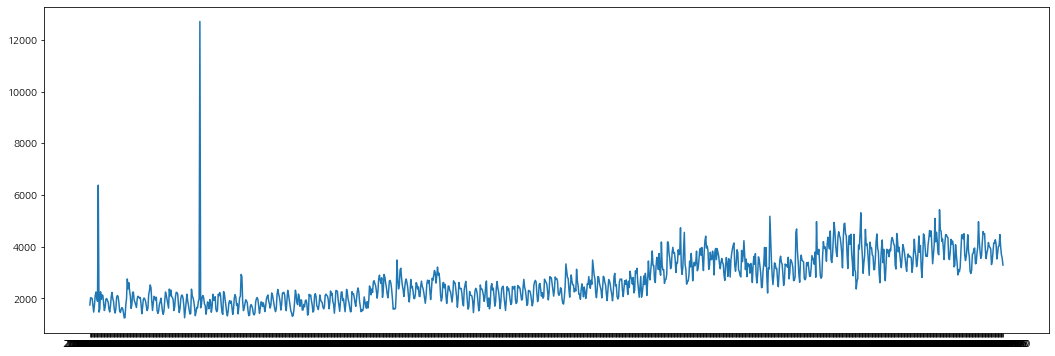

- 2018년 5월 25일에 검색량 최대치 기록
- 관련 이슈 
     - 1) 배우 이호원(인피니트 호야)이 라디오스타에서 오메가3, 비타민C, 프로폴리스 언급 
     http://www.topstarnews.net/news/articleView.html?idxno=417586
     - 2) 배우 김소연이 운동은 안하는데(...) 오메가3를 먹는다고 발언
     http://www.newsworks.co.kr/news/articleView.html?idxno=189197
     - 3) KBS 무엇이든 물어보세요에 24일 방송됨
     http://www.sommeliertimes.com/news/articleView.html?idxno=8807
 

### 단백질 보충제(헬스 보충제)
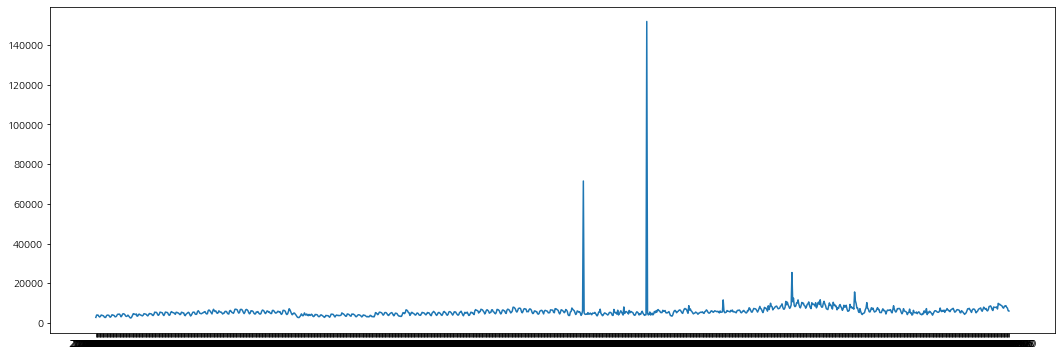

- 2019년 12월 23일, 그 다음으로 2019년 10월 1일에 검색량 최대치 기록
- 관련 이슈
    - 1) 2019년 10월 1일 : 식약처 단백질 보충제 244개 조사 -> 불법 스테로이드 발견 + 거짓, 과장광고 적발 
     https://biz.sbs.co.kr/article/10000956939?division=NAVER
    - 2) 2019년 12월 23일 : 해외직구 단백질 보충제에서 부적합 스테로이드 성분 검출, 통관 차단 요청
     https://biz.chosun.com/site/data/html_dir/2019/12/23/2019122300967.html?utm_source=naver&utm_medium=original&utm_campaign=biz

### 프로바이오틱스
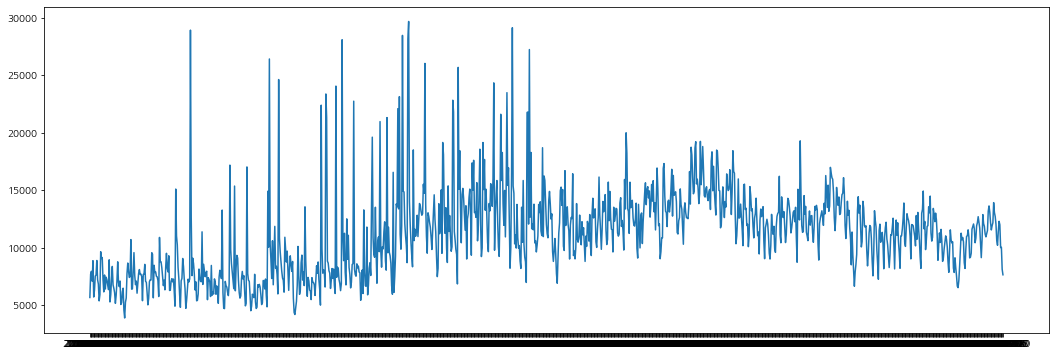

- 프로바이오틱스는 인기 상품이라 자주 방송되는 것 같은데, 일단 검색량 최대치인 날은 2019년 5월 6일
- 관련 이슈
    - 1) SBS 스페셜에서 프리바이오틱스, 프로바이오틱스 방송 
    - 이 시기에 프리바이오틱스도 함께 검색량 증가 
    http://daily.hankooki.com/lpage/entv/201905/dh20190506005531139030.htm

### 양태반
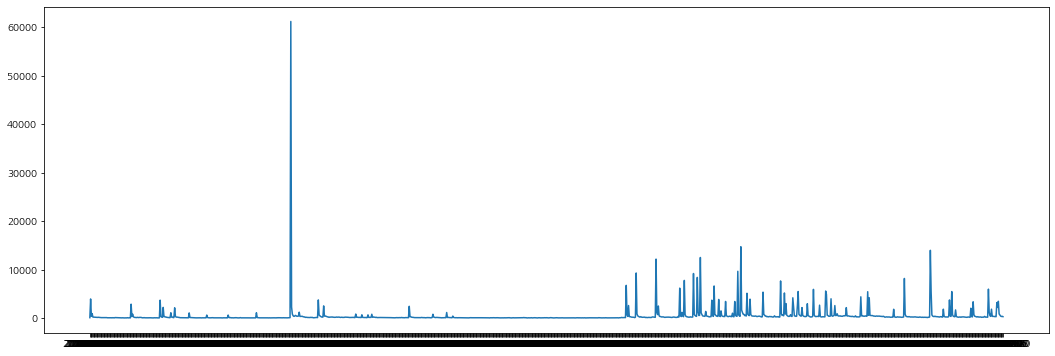
- 2018년 9월 21일에 검색량 최대치 기록 
- 관련 이슈
    - 1) 내 몸 사용 설명서 219회에서 회춘 비결로 등장
    https://cratos112.com/546


### 초록입홍합
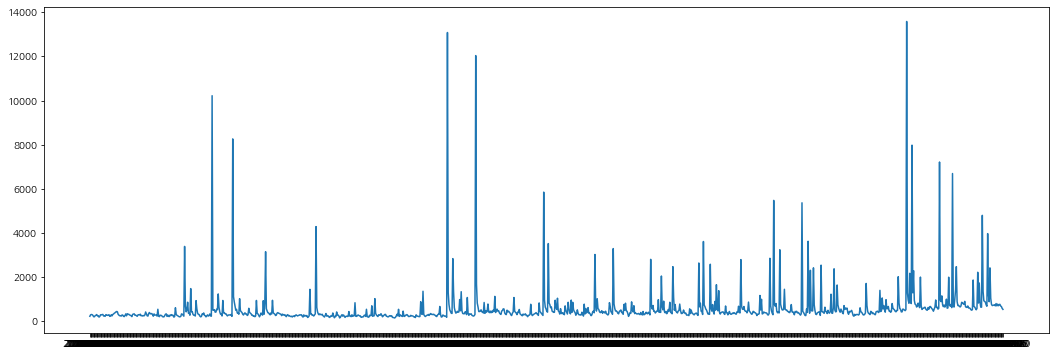

- 2020년 12월 5일에 검색량 최대치 기록
- 관련 이슈
    - 1) 12월 초 "개는 훌륭하다" 방송에 강아지 영양식으로 초록입홍합 성분을 포함한 영양식 등장
    - 2) 이 때 관련 기사, 블로그 체험단 리뷰가 같이 증가했으며 
    - 3) 해당 브랜드에서는 할인이벤트도 함께 진행함 
    https://www.news1.kr/articles/?4135799
    - 4) 참고로 2021 1월에도 방송 출연 + 홍보 진행함. 그래서 검색량이 떨어지지 않고 이어지는 것으로 볼 수 있음
    http://www.youngnong.co.kr/news/articleView.html?idxno=32858

In [ ]:
###공사중 

"""
fig, axes = plt.subplots(nrows = (30 // 3)+1, ncols = 3, figsize = (20, 70)) 
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

cate_list = list(df_realvalue.columns)

for index, cate_name in enumerate(cate_list): 
    
    data = pd.DataFrame(df_test_real[cate_name])
    
    ax = sns.lineplot(x= list(data.index), y = data[cate_name], data=data, 
                     ax = axes[index//3, index%3])
    
    ax.set_title(cate_name)
    
    ax.set_ylabel("search")
 
plt.show()
"""